# Connectome data

In [1]:
import datetime
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from giskard.match import GraphMatchSolver
from giskard.plot import matched_stripplot
from pkg.data import load_split_connectome
from pkg.io import OUT_PATH
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import method_palette, set_theme
from scipy.stats import wilcoxon
from tqdm import tqdm


FILENAME = "connectomes"

DISPLAY_FIGS = True

OUT_PATH = OUT_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
rng = np.random.default_rng(8888)

## Load processed data, run matching experiment

In [2]:


def get_hemisphere_indices(nodes):
    nodes = nodes.copy()
    nodes["_inds"] = np.arange(len(nodes))
    left_nodes = nodes[nodes["hemisphere"] == "L"]
    right_nodes = nodes[nodes["hemisphere"] == "R"]
    assert (left_nodes["pair"].values == right_nodes["pair"].values).all()
    left_indices = left_nodes["_inds"].values
    right_indices = right_nodes["_inds"].values
    return left_indices, right_indices


RERUN_SIMS = False
datasets = ["maggot_subset", "male_chem", "herm_chem", "specimen_148", "specimen_107"]

n_sims = 50
glue("n_initializations", n_sims)

results_by_dataset = {}
for dataset in datasets:
    adj, nodes = load_split_connectome(dataset)
    n_nodes = len(nodes)
    glue(f"{dataset}_n_nodes", n_nodes, form="long")
    n_edges = np.count_nonzero(adj)
    glue(f"{dataset}_n_edges", n_edges, form="long")
    if RERUN_SIMS:
        left_inds, right_inds = get_hemisphere_indices(nodes)
        A = adj[left_inds][:, left_inds]
        B = adj[right_inds][:, right_inds]
        AB = adj[left_inds][:, right_inds]
        BA = adj[right_inds][:, left_inds]
        n_side = len(left_inds)
        seeds = rng.integers(np.iinfo(np.uint32).max, size=n_sims)
        rows = []
        for sim, seed in enumerate(tqdm(seeds, leave=False)):
            for method in ["GM", "BGM"]:
                if method == "GM":
                    solver = GraphMatchSolver(A, B, rng=seed)
                elif method == "BGM":
                    solver = GraphMatchSolver(A, B, AB=AB, BA=BA, rng=seed)
                run_start = time.time()
                solver.solve()
                match_ratio = (solver.permutation_ == np.arange(n_side)).mean()
                elapsed = time.time() - run_start
                rows.append(
                    {
                        "match_ratio": match_ratio,
                        "sim": sim,
                        "method": method,
                        "seed": seed,
                        "elapsed": elapsed,
                        "converged": solver.converged,
                        "n_iter": solver.n_iter,
                        "score": solver.score_,
                    }
                )

        results = pd.DataFrame(rows)
        results.to_csv(OUT_PATH / f"{dataset}_match_results.csv")
    else:
        results = pd.read_csv(OUT_PATH / f"{dataset}_match_results.csv", index_col=0)
    results_by_dataset[dataset] = results

## Plot the matching accuracy showing each random seed

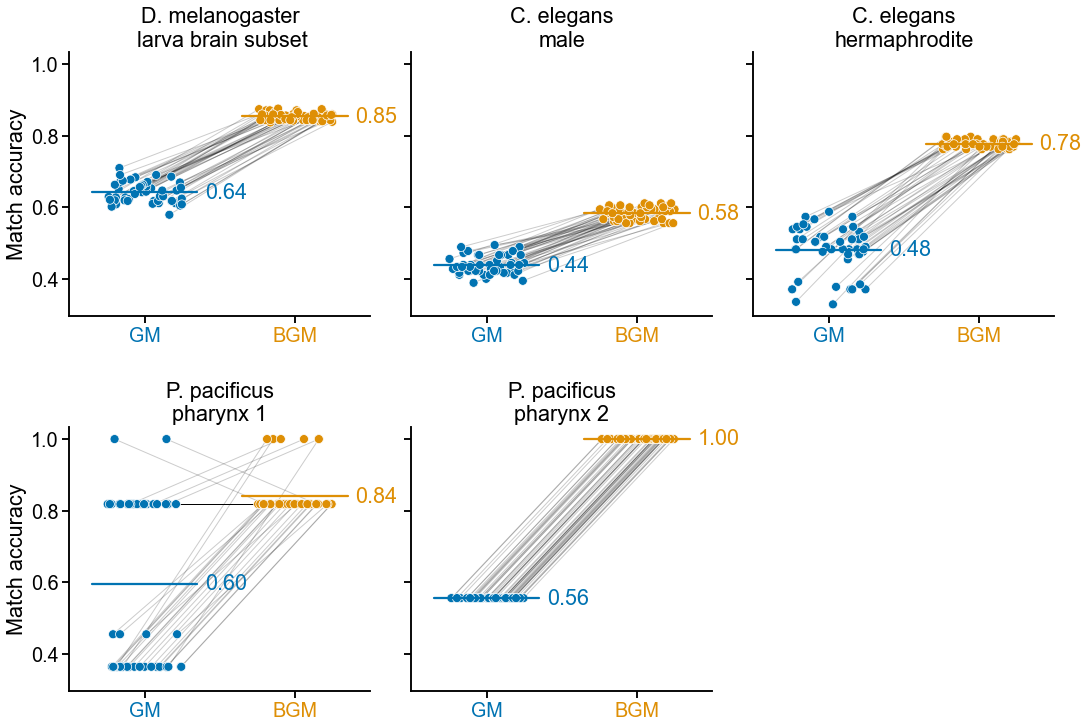

In [3]:

set_theme(font_scale=1.2)
scale = 5
jitter = 0.25
meanline_width = 0.35
n_datasets = len(datasets)
order = ["GM", "BGM"]
nice_dataset_map = {
    "herm_chem": "C. elegans\nhermaphrodite",
    "male_chem": "C. elegans\nmale",
    "maggot": "Maggot",
    "maggot_subset": "D. melanogaster\n larva brain subset",
    "specimen_107": "P. pacificus\npharynx 2",
    "specimen_148": "P. pacificus\npharynx 1",
}

n_rows = int(np.ceil(n_datasets / 3))
n_cols = min(n_datasets, 3)
fig, axs = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * scale, n_rows * scale),
    sharey=True,
    constrained_layout=True,
    gridspec_kw=dict(hspace=0.1),
)
pvalues = {}

for i, (dataset, results) in enumerate(results_by_dataset.items()):
    index = np.unravel_index(i, (n_rows, n_cols))
    ax = axs[index]
    matched_stripplot(
        data=results,
        x="method",
        y="match_ratio",
        match="sim",
        order=order,
        hue="method",
        palette=method_palette,
        ax=ax,
        jitter=jitter,
        legend=False,
    )

    ax.tick_params(which="both", length=7)
    ax.set_ylabel("Match accuracy")
    ax.set_xlabel("")
    ax.set_title(nice_dataset_map[dataset])

    ticklabels = ax.get_xticklabels()
    for ticklabel in ticklabels:
        method = ticklabel.get_text()
        ticklabel.set_color(method_palette[method])

    gm_results = results[results["method"] == "GM"]
    bgm_results = results[results["method"] == "BGM"]

    stat, pvalue = wilcoxon(
        gm_results["match_ratio"].values,
        bgm_results["match_ratio"].values,
        mode="approx",
    )
    glue(f"{dataset}_match_ratio_pvalue", pvalue, form="pvalue")
    pvalues[dataset] = pvalue

    improvement = bgm_results["match_ratio"].mean() - gm_results["match_ratio"].mean()
    glue(f"{dataset}_mean_accuracy_change", improvement, form="2.0f%")

    for i, method in enumerate(order):
        mean_match_ratio = results[results["method"] == method]["match_ratio"].mean()
        ax.plot(
            [i - meanline_width, i + meanline_width],
            [mean_match_ratio, mean_match_ratio],
            color=method_palette[method],
        )
        ax.text(
            i + meanline_width + 0.05,
            mean_match_ratio,
            f"{mean_match_ratio:0.2f}",
            color=method_palette[method],
            va="center",
            ha="left",
            fontsize="medium",
        )
        glue(f"{dataset}_{method}_mean_match_accuracy", mean_match_ratio)

    ax.set_xlim((-0.5, 1.5))
    ax.set_yticks([0.45, 0.6, 0.75, 0.9])
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

for ax in axs.flat:
    if not ax.has_data():
        ax.axis("off")

# gluefig("match_accuracy_comparison_lines", fig)

## Plot the matching accuracy in aggregate

In [4]:

all_results = []
for dataset, results in results_by_dataset.items():
    results["dataset"] = dataset
    all_results.append(results)
all_results = pd.concat(all_results)
all_results

,match_ratio,sim,method,seed,elapsed,converged,n_iter,score,dataset
0,0.653226,0,GM,200426005,7.254859,False,30,0,maggot_subset
1,0.856452,0,BGM,200426005,1.860270,True,10,0,maggot_subset
2,0.645161,1,GM,1087836691,5.353300,False,30,0,maggot_subset
3,0.843548,1,BGM,1087836691,2.989529,True,16,0,maggot_subset
4,0.627419,2,GM,2808301671,5.532718,False,30,0,maggot_subset
...,...,...,...,...,...,...,...,...,...
95,1.000000,47,BGM,3948372264,0.000713,True,3,0,specimen_107
96,0.555556,48,GM,1655188775,0.000820,True,4,0,specimen_107
97,1.000000,48,BGM,1655188775,0.000713,True,3,0,specimen_107
98,0.555556,49,GM,2605143165,0.000836,True,4,0,specimen_107


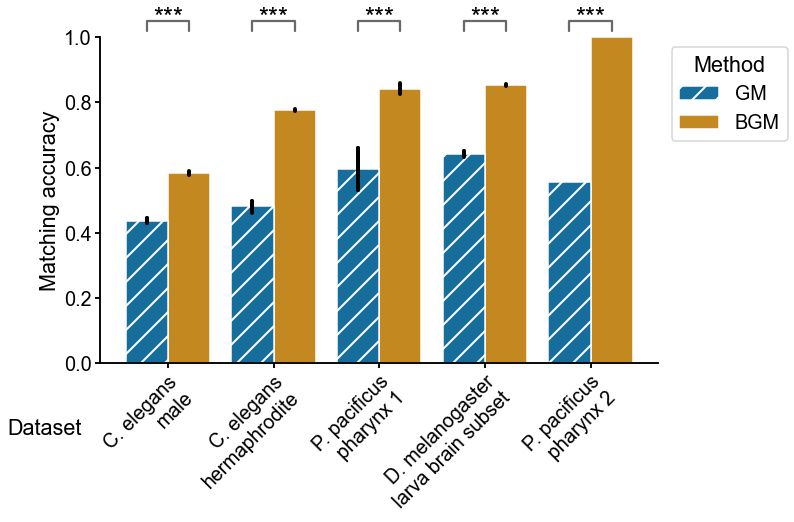

In [5]:

mpl.rcParams["hatch.linewidth"] = 2.0

set_theme(font_scale=1.2)
order = all_results.groupby("dataset")["match_ratio"].mean().sort_values().index
fig, ax = plt.subplots(1, 1, figsize=(10, 6))


sns.barplot(
    data=all_results,
    x="dataset",
    order=order,
    hue_order=["GM", "BGM"],
    y="match_ratio",
    hue="method",
    ax=ax,
    palette=method_palette,
    edgecolor="white",
    zorder=0,
    errcolor=".0",
    errwidth=4,
)
# hack to add hatches to only one plot
sns.barplot(
    data=all_results[all_results["method"] == "GM"],
    x="dataset",
    order=order,
    hue_order=["GM", "BGM"],
    y="match_ratio",
    hue="method",
    ax=ax,
    palette=method_palette,
    hatch="/",
    zorder=1,
    edgecolor="white",
    errcolor=".0",
    errwidth=4,
)

leg = ax.get_legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles[1:3][::-1],
    labels=labels[1:3][::-1],
    title="Method",
    loc="upper right",
    bbox_to_anchor=(1.25, 1),
    frameon=True,
)

ax.set(ylabel="Matching accuracy")
plt.setp(
    ax.get_xticklabels(), rotation=45, ha="right", va="top", rotation_mode="anchor"
)
ax.tick_params(length=5)
ax.set_xticklabels(order.map(nice_dataset_map))


def draw_significance(pvalue, x, xdist, y=1.02, ydist=0.03):
    if pvalue < 0.0005:
        text = "***"
    elif pvalue < 0.005:
        text = "**"
    elif pvalue < 0.05:
        text = "*"
    else:
        text = ""
    if text != "":
        ax.plot(
            [x - xdist, x - xdist, x + xdist, x + xdist],
            [y, y + ydist, y + ydist, y],
            color="dimgrey",
            clip_on=False,
        )
        ax.text(x, y, text, ha="center", va="bottom", fontsize="large")


for i, dataset in enumerate(order):
    pvalue = pvalues[dataset]
    draw_significance(pvalue, i, 0.2)

ax.set_ylim((ax.get_ylim()[0], 1))

ax.set_xlabel("Dataset")
ax.xaxis.set_label_coords(-0.1, -0.17)

gluefig("match_accuracy_comparison", fig)

## End

In [6]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:04.613673
Completed at 2022-05-13 13:41:40.048548
